In [128]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
data_path = "../data/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)

(49352, 15)
(74659, 14)


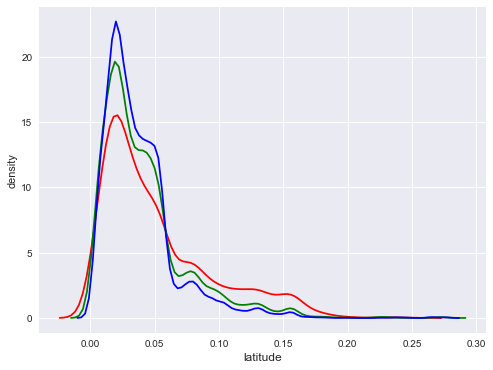

In [101]:
#center_x, center_y = -73.968285, 40.785091
center_x, center_y = -73.98, 40.75
train_df['distance_city'] = ((train_df['longitude']-center_x)**2 + (train_df['latitude']-center_y)**2)**0.5
interest_high = np.array(list(filter(lambda x: x[7] == 'high', train_df.values)))
interest_medium = np.array(list(filter(lambda x: x[7] == 'medium', train_df.values)))
interest_low = np.array(list(filter(lambda x: x[7] == 'low', train_df.values)))

plt.figure(figsize=(8,6))
sns.distplot(interest_high[:,-1], hist=False, kde=True, color='r')
sns.distplot(interest_medium[:,-1], hist=False, kde=True, color='g')
sns.distplot(interest_low[:,-1], hist=False, kde=True, color='b')
plt.xlabel('latitude', fontsize=12)
plt.ylabel('density')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


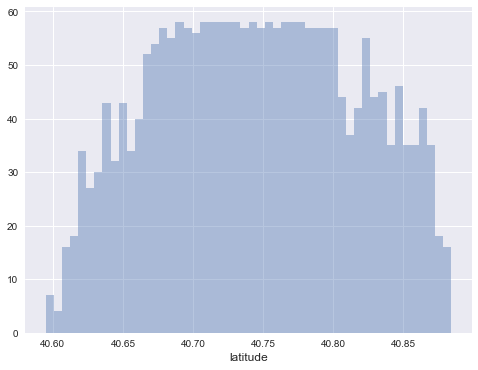

In [50]:
llimit = np.percentile(list(set(train_df.latitude.values)), 0.5)
ulimit = np.percentile(list(set(train_df.latitude.values)), 99.5)
train_df['latitude'].ix[train_df['latitude']<llimit] = llimit
train_df['latitude'].ix[train_df['latitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(list(set(train_df.latitude.values)), bins=50, kde=False)
plt.xlabel('latitude', fontsize=12)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


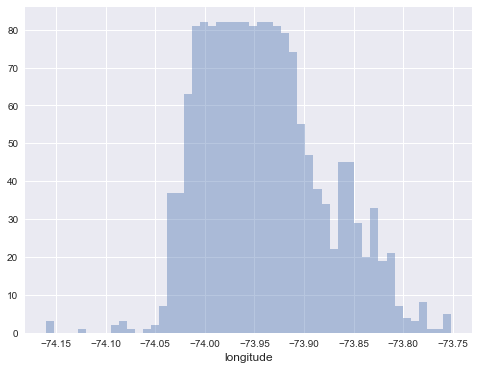

In [4]:
llimit = np.percentile(list(set(train_df.longitude.values)), 1)
ulimit = np.percentile(list(set(train_df.longitude.values)), 99)
train_df['longitude'].ix[train_df['longitude']<llimit] = llimit
train_df['longitude'].ix[train_df['longitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(list(set(train_df.longitude.values)), bins=50, kde=False)
plt.xlabel('longitude', fontsize=12)
plt.show()

In [5]:
img=mpimg.imread('../data/ny.png')

In [6]:
x = train_df['longitude'].values
y = train_df['latitude'].values

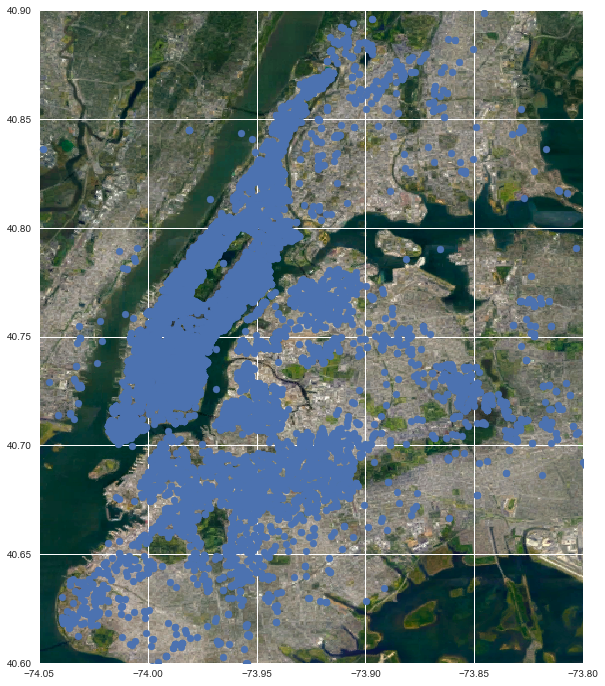

In [7]:
west, south, east, north = -74.05, 40.60, -73.80, 40.90
plt.figure(figsize=((east-west)*40, (north-south)*40))
plt.imshow(img, extent=(west, east, south, north))
plt.scatter(x,y)
plt.xlim(west, east)
plt.ylim(south, north)
plt.show()

In [19]:
X = set(filter(lambda x: west<x[0]<east and south<x[1]<north, zip(x,y)))
X = np.array(list(X))
print(X.shape)
X = np.array(random.sample(X.tolist(),2000))

(10798, 2)


In [45]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

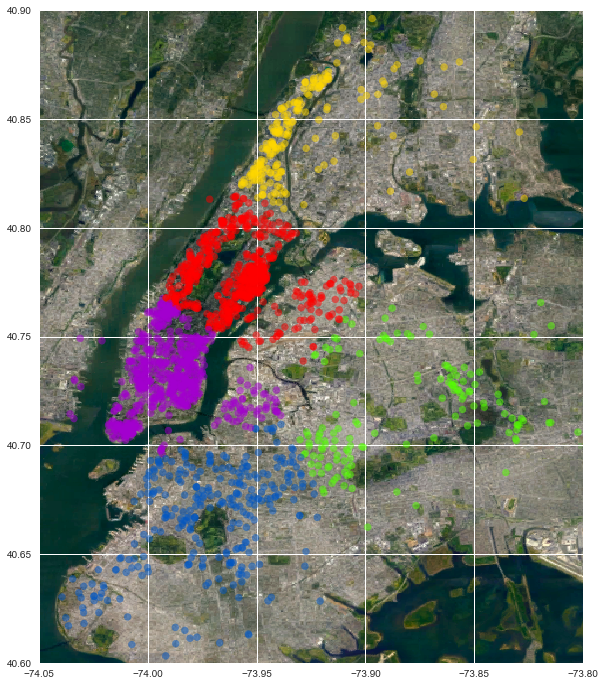

In [46]:
plt.figure(figsize=((east-west)*40, (north-south)*40))
plt.imshow(img, extent=(west, east, south, north))
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='prism', alpha=0.5)
plt.xlim(west, east)
plt.ylim(south, north)
plt.show()

In [23]:
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [24]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [38]:
Z = linkage(X, 'ward')

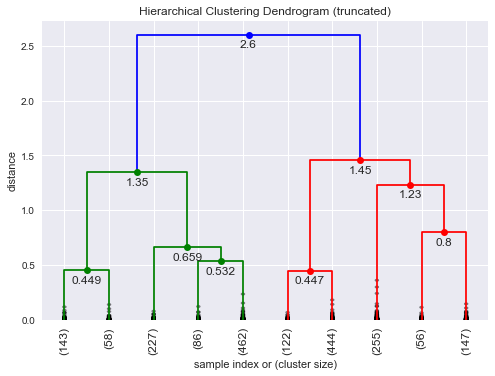

In [41]:
max_d = 1.5
fancy_dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    show_contracted=True,  # to get a distribution impression in truncated branches
    annotate_above=0.3,
    #max_d=max_d,
)
plt.show()

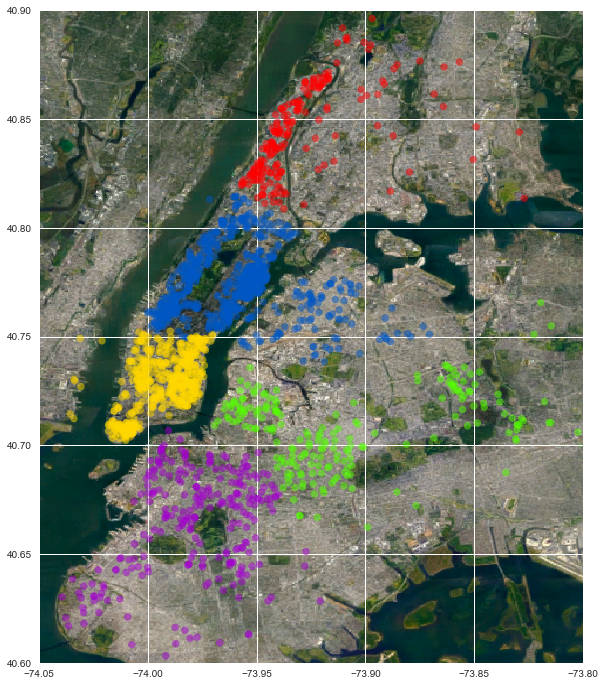

In [44]:
k=5
clusters = fcluster(Z, k, criterion='maxclust')
plt.figure(figsize=((east-west)*40, (north-south)*40))
plt.imshow(img, extent=(west, east, south, north))
plt.scatter(X[:,0],X[:,1], c=clusters, cmap='prism', alpha=0.5)
plt.xlim(west, east)
plt.ylim(south, north)
plt.show()

In [124]:
qda = QDA()
qda.fit(X, clusters)
all_clusters = qda.predict(np.array(list(zip(x,y))))

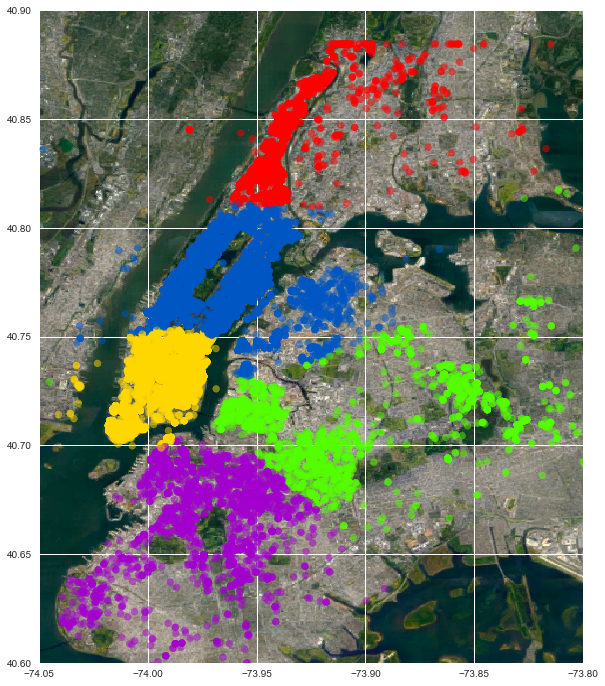

In [125]:
all_X = np.array(list(zip(x,y)))
plt.figure(figsize=((east-west)*40, (north-south)*40))
plt.imshow(img, extent=(west, east, south, north))
plt.scatter(all_X[:,0],all_X[:,1], c=all_clusters, cmap='prism', alpha=0.5)
plt.xlim(west, east)
plt.ylim(south, north)
plt.show()

In [139]:
def get_qda(k=5, sample=0.3):
    west, south, east, north = -74.05, 40.60, -73.80, 40.90
    x = train_df['longitude'].values
    y = train_df['latitude'].values
    X = set(filter(lambda x: west<x[0]<east and south<x[1]<north, zip(x,y)))
    X = np.array(list(X))
    X = np.array(random.sample(X.tolist(),int(len(X)*sample)))
    Z = linkage(X, 'ward')
    clusters = fcluster(Z, k, criterion='maxclust')
    qda = QDA()
    qda.fit(X, clusters)
    return qda

def predict(qda, X):
    return qda.predict(X)
    

In [140]:
qda = get_qda()

In [141]:
c = predict(qda, np.array(list(zip(x,y))))

In [142]:
c

array([5, 2, 3, ..., 3, 3, 1], dtype=int32)

In [ ]:
train_df['cluster'] = 